 Data Collection (Stock Prices + Sentiment Analysis)
 
  1. Stock Price Data ( alpha vantage API)
  We’ll use to collect historical stock prices (Open, High, Low, Close, Volume).

In [52]:
from alpha_vantage.timeseries import TimeSeries
import pandas as pd

API_KEY = "P3LQ4XJ9PACNYTHH"  

ts = TimeSeries(key=API_KEY, output_format="pandas")
stock_data, meta_data = ts.get_daily(symbol="JPM", outputsize="full")

# Save to CSV
stock_data.to_csv("jpm_stock_data.csv")
print("Stock data saved successfully!")




Stock data saved successfully!


 2. Preprocessing Data (Handling missing values, normalizing).

In [53]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Load stock data
df = pd.read_csv("jpm_stock_data.csv")
df = df.iloc[::-1]  # Reverse order so that oldest data is first

# Convert date column to datetime format
df.index = pd.to_datetime(df.index)

# Select only relevant columns (Open, High, Low, Close, Volume)
df = df[['1. open', '2. high', '3. low', '4. close', '5. volume']]
df.columns = ['Open', 'High', 'Low', 'Close', 'Volume']

# Check for missing values
print("Missing values:\n", df.isnull().sum())

# Normalize using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(df)

# Convert back to DataFrame
df_scaled = pd.DataFrame(df_scaled, columns=df.columns, index=df.index)

print("\nPreprocessing Done! Data is now scaled.")
df_scaled.head()



Missing values:
 Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

Preprocessing Done! Data is now scaled.


,Open,High,Low,Close,Volume
1970-01-01 00:00:00.000006377,0.270654,0.268170,0.260848,0.257505,0.017261
1970-01-01 00:00:00.000006376,0.262603,0.264873,0.260390,0.257996,0.012784
1970-01-01 00:00:00.000006375,0.259261,0.256347,0.256349,0.253270,0.008661
1970-01-01 00:00:00.000006374,0.260249,0.263698,0.261344,0.259622,0.014299
1970-01-01 00:00:00.000006373,0.268793,0.269155,0.269427,0.267675,0.012284


Feature Engineering ; 
Simple Moving Averages (SMA) – Averages of closing prices over different time windows 
Exponential Moving Averages (EMA) – Similar to SMA but gives more weight to recent prices.
Relative Strength Index (RSI) – Measures momentum to see if a stock is overbought/oversold.
MACD (Moving Average Convergence Divergence) – Identifies trend changes.

In [54]:
# Import required libraries
import pandas as pd

# Function to calculate Relative Strength Index (RSI)
def calculate_rsi(data, window=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

# Moving Averages
df_scaled['SMA_14'] = df_scaled['Close'].rolling(window=14).mean()
df_scaled['SMA_50'] = df_scaled['Close'].rolling(window=50).mean()
df_scaled['EMA_14'] = df_scaled['Close'].ewm(span=14, adjust=False).mean()

# RSI Indicator
df_scaled['RSI_14'] = calculate_rsi(df_scaled['Close'], window=14)

# MACD Calculation
ema_12 = df_scaled['Close'].ewm(span=12, adjust=False).mean()
ema_26 = df_scaled['Close'].ewm(span=26, adjust=False).mean()
df_scaled['MACD'] = ema_12 - ema_26

# Drop NaN values (from rolling calculations)
df_scaled.dropna(inplace=True)

print("Feature Engineering Done! New features added.")
df_scaled.head()


Feature Engineering Done! New features added.


,Open,High,Low,Close,Volume,SMA_14,SMA_50,EMA_14,RSI_14,MACD
1970-01-01 00:00:00.000006328,0.207538,0.204964,0.203195,0.205520,0.022308,0.221988,0.237996,0.218811,35.811919,-0.007702
1970-01-01 00:00:00.000006327,0.206361,0.206631,0.207962,0.207183,0.018817,0.220737,0.236990,0.217260,37.560451,-0.007955
1970-01-01 00:00:00.000006326,0.211829,0.212770,0.212003,0.211191,0.017730,0.219066,0.236054,0.216451,31.847507,-0.007742
1970-01-01 00:00:00.000006325,0.222501,0.225085,0.220583,0.220907,0.026391,0.218358,0.235406,0.217045,42.964554,-0.006712
1970-01-01 00:00:00.000006324,0.222501,0.220349,0.210821,0.210019,0.012735,0.216889,0.234414,0.216108,37.313433,-0.006697


Training ML Models ;
Defining the target (y) and features (X)
Splitting data into training & testing sets

Train models:
Linear Regression (Baseline model)
XGBoost (More advanced)


In [55]:
# Import libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import xgboost as xgb

# Define target variable (Close Price) and feature set
X = df_scaled.drop(columns=['Close'])  # All features except the target
y = df_scaled['Close']  # Target variable

# Split data (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# 1 Train Linear Regression Model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Make predictions
y_pred_lr = lr_model.predict(X_test)

# Evaluate Linear Regression
mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))

print(f"Linear Regression - MAE: {mae_lr:.4f}, RMSE: {rmse_lr:.4f}")

# 2 Train XGBoost Model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate XGBoost
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))

print(f"XGBoost - MAE: {mae_xgb:.4f}, RMSE: {rmse_xgb:.4f}")



Linear Regression - MAE: 0.0026, RMSE: 0.0034
XGBoost - MAE: 0.0898, RMSE: 0.1529


Tuning the XGBoost

In [56]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
import numpy as np

# Define parameter grid
param_dist = {
    'n_estimators': [50, 100, 200, 300, 400],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': np.linspace(0.01, 0.3, 10),
    'subsample': np.linspace(0.5, 1, 5),
    'colsample_bytree': np.linspace(0.5, 1, 5)
}

# Initialize XGBoost Regressor
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Randomized Search
random_search = RandomizedSearchCV(
    xgb_reg, param_distributions=param_dist,
    n_iter=20, scoring='neg_mean_absolute_error', 
    cv=5, verbose=1, random_state=42, n_jobs=-1
)

# Train the model with Randomized Search
random_search.fit(X_train, y_train)

# Best parameters
print("Best Parameters:", random_search.best_params_)

# Evaluate on test data
best_xgb = random_search.best_estimator_
y_pred = best_xgb.predict(X_test)

# Performance metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Optimized XGBoost - MAE: {mae:.4f}, RMSE: {rmse:.4f}")


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters: {'subsample': np.float64(0.5), 'n_estimators': 100, 'max_depth': 7, 'learning_rate': np.float64(0.1711111111111111), 'colsample_bytree': np.float64(1.0)}
Optimized XGBoost - MAE: 0.0907, RMSE: 0.1540


Deep Learning Approach: Moving to LSTMs for better time-series predictions.

In [57]:
# Ensure the necessary imports
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Assuming 'df' is your original DataFrame with stock prices
scaler = MinMaxScaler(feature_range=(0, 1))

# Selecting the column for training (e.g., 'Close' price)
scaled_data = scaler.fit_transform(df[['Close']].values)

# Now try creating sequences
time_steps = 60
X_lstm, y_lstm = create_sequences(scaled_data, time_steps)

# Reshape for LSTM input
X_lstm = X_lstm.reshape(X_lstm.shape[0], X_lstm.shape[1], 1)

print(f"LSTM Input Shape: {X_lstm.shape}")
print(f"LSTM Output Shape: {y_lstm.shape}")



LSTM Input Shape: (6318, 60, 1)
LSTM Output Shape: (6318, 1)


C:\Users\dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - loss: 0.0052 - val_loss: 9.6426e-04
Epoch 2/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 3.8980e-04 - val_loss: 0.0017
Epoch 3/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 3.7766e-04 - val_loss: 4.4572e-04
Epoch 4/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 3.0990e-04 - val_loss: 6.2539e-04
Epoch 5/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 2.9603e-04 - val_loss: 5.6568e-04
Epoch 6/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 2.5978e-04 - val_loss: 0.0013
Epoch 7/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 2.3709e-04 - val_loss: 7.7885e-04
Epoch 8/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 2.3309e-04 - val_loss: 5.3185e-04
Epoch 9/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - loss: 2.3779e-04 - val_loss: 3.2069e-04
Epoch 10/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - loss: 2.0678e-04 - val_loss: 6.6451e-04
Epoch 11/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - loss

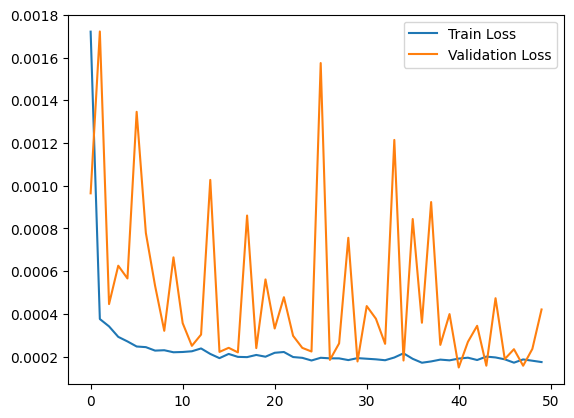

In [58]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Define the LSTM model
model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(X_lstm.shape[1], 1)),
    Dropout(0.2),
    LSTM(units=50, return_sequences=False),
    Dropout(0.2),
    Dense(units=25),
    Dense(units=1)  # Output layer for price prediction
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_lstm, y_lstm, epochs=50, batch_size=32, validation_split=0.1)

# Plot training history (optional)
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()


Evaluating Performance:
1.We’ll calculate key evaluation metrics like -

  RMSE (Root Mean Square Error)
  MAE (Mean Absolute Error)

2.Visualize Model Predictions vs. Actual Values
  Plot predicted vs. actual stock prices to see how well the model performs.
  Use a time-series plot to compare them over time.

Root Mean Square Error (RMSE): 0.15395960077891407
Mean Absolute Error (MAE): 0.0906725463574863


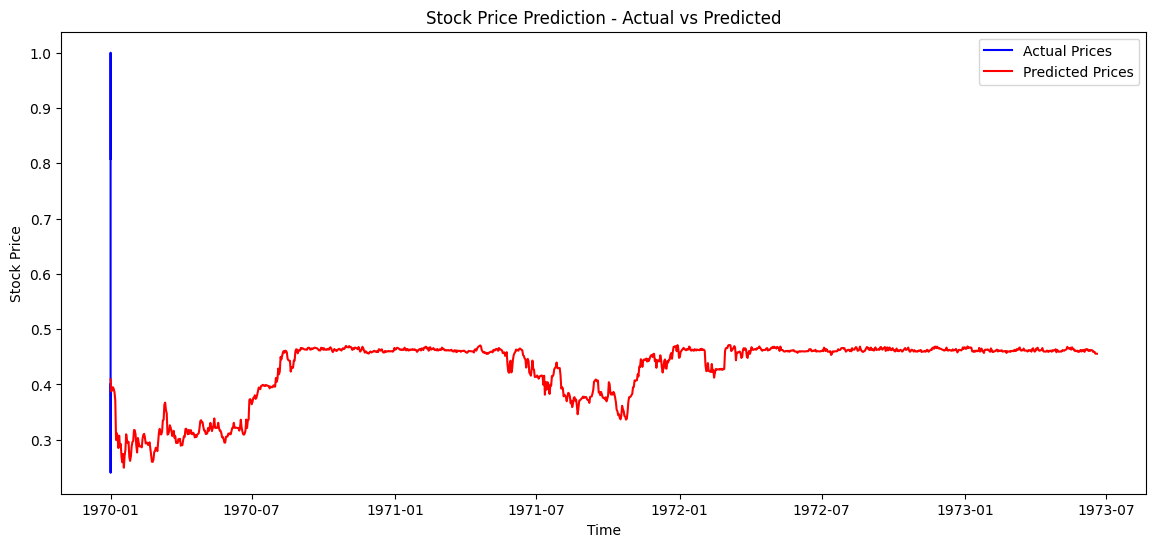

In [59]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Assuming 'y_test' contains actual values and 'y_pred' contains model predictions
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f"Root Mean Square Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")

import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(y_test, label="Actual Prices", color='blue')
plt.plot(y_pred, label="Predicted Prices", color='red')
plt.title("Stock Price Prediction - Actual vs Predicted")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend()
plt.show()


visualizing the predicted vs. actual stock prices over time. Run this and check how well the model tracks real stock prices:

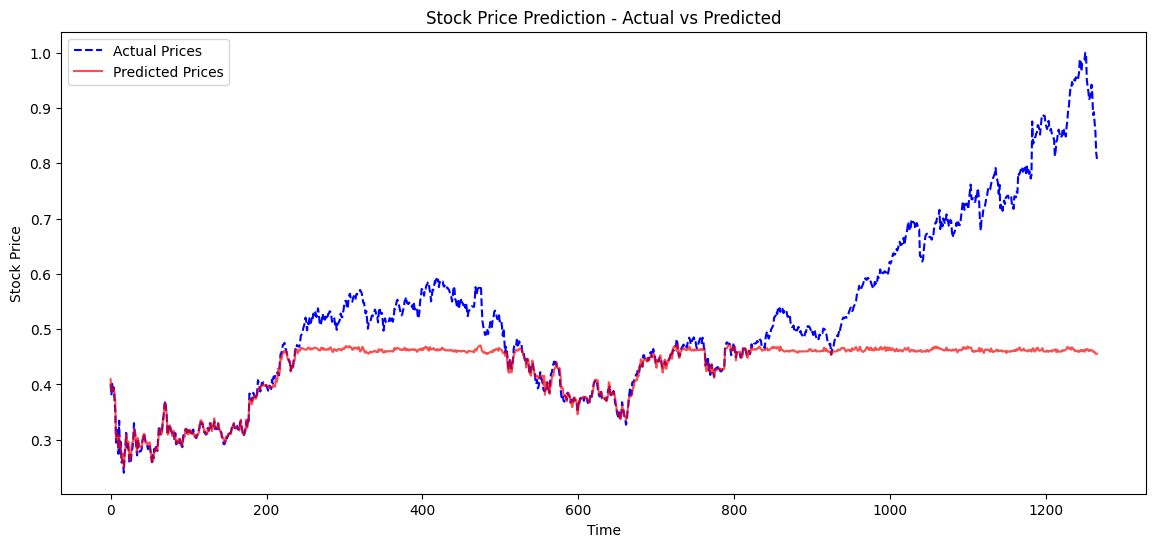

In [60]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(y_test.values, label="Actual Prices", color='blue', linestyle='dashed')
plt.plot(y_pred, label="Predicted Prices", color='red', alpha=0.7)
plt.title("Stock Price Prediction - Actual vs Predicted")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend()
plt.show()



Checking R^2 Score (Goodness of Fit); 

In [61]:
from sklearn.metrics import r2_score

r2 = r2_score(y_test, y_pred)
print(f"R² Score: {r2:.4f}")


R² Score: 0.0468
